In [2]:
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [7]:
datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

'30-10-2020_17-21-30'

In [83]:
with open('Data/traj02-11-2020_16-14-45.pkl','rb') as f:
    traj = pickle.load(f)

In [84]:
def filter_by_loc(traj):
    locs = np.array(traj['loc'])
    loc = []
    rew = []
    obs = []
    for i in range(locs.shape[0]):
        if locs[i,0]!=0 and locs[i,1]!=0:
            if locs[i,0]<1000:
                loc.append(locs[i,:])
                rew.append(traj['reward'][i])
                obs.append(traj['obs'][i])
    return np.array(loc),np.array(rew),np.array(obs)

In [85]:
loc,rew,obs = filter_by_loc(traj)

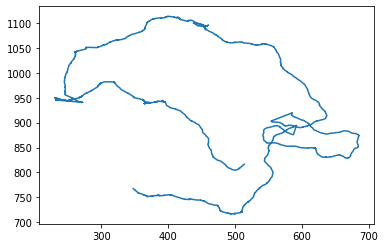

In [86]:
plt.plot(locs[:,0],locs[:,1])

In [21]:
traj.keys()

dict_keys(['loc', 't', 'endpts', 'obs', 'reward', 'target', 'action'])

In [4]:
obs = np.array(traj['obs'])

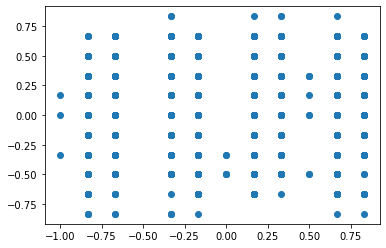

In [6]:
plt.scatter(obs[:,0],obs[:,1])

(array([343., 261.,   1., 589.,   0.,   0., 699.,   1., 331., 274.]),
 array([-8.33333333e-01, -6.66666667e-01, -5.00000000e-01, -3.33333333e-01,
        -1.66666667e-01,  1.11022302e-16,  1.66666667e-01,  3.33333333e-01,
         5.00000000e-01,  6.66666667e-01,  8.33333333e-01]),
 <BarContainer object of 10 artists>)

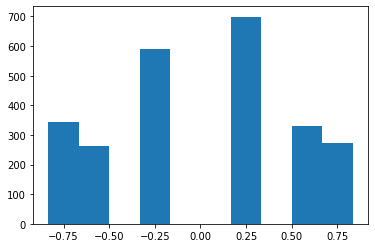

In [91]:
plt.hist(obs[:,0])

(array([  1., 112., 179., 263., 534., 301., 589., 368., 105.,  47.]),
 array([-1.        , -0.81666667, -0.63333333, -0.45      , -0.26666667,
        -0.08333333,  0.1       ,  0.28333333,  0.46666667,  0.65      ,
         0.83333333]),
 <BarContainer object of 10 artists>)

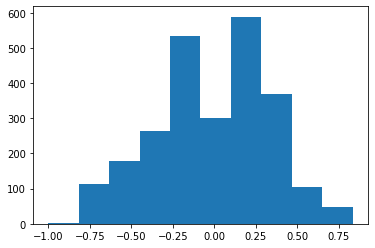

In [90]:
plt.hist(obs[:,1])

In [81]:
H, xedges, yedges = np.histogram2d(obs[:,0], obs[:,1], bins=(np.linspace(-1,1,12), np.linspace(-1,1,12)))

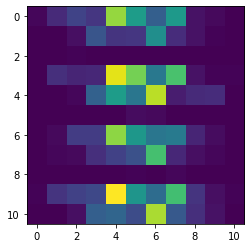

In [82]:
plt.imshow(H)

In [87]:
H, xedges, yedges = np.histogram2d(obs[:,0], obs[:,1], bins=(np.linspace(-1,1,12), np.linspace(-1,1,12)))

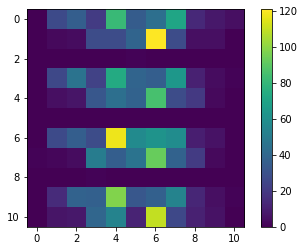

In [89]:
plt.imshow(H)
plt.colorbar()

In [93]:
obs

array([[-0.33333333, -0.16666667],
       [ 0.66666667, -0.16666667],
       [ 0.66666667, -0.33333333],
       ...,
       [ 0.16666667,  0.33333333],
       [ 0.16666667, -0.66666667],
       [ 0.16666667,  0.33333333]])

In [ ]:
def reward_dist(traj):
    # Returns reward means and std for each state.
    def ang_to_ind(ang):
        # Maps from [-1,1] to [0,10]
        return (ang+1)*6
    loc,rew,obs = filter_by_loc(traj)